# COVID-19 Prediction Analysis on Locations with 

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [3]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
# from imblearn.metrics import classificationn_report_imbalanced 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
# import keras_tuner as kt

## Data Source

In [4]:
# Load the cases prediction cleaned data file.
cases_2yr_file_path = Path('./Resources/cases_1mill_2yr_df.csv')
df = pd.read_csv(cases_2yr_file_path)
print(df.shape)
df.head()

(88039, 26)


,id_row,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
0,34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
1,35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
2,36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
3,37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
4,38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [5]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(88039, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [6]:
df.location.nunique()

150

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88039 entries, 34 to 198655
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   location                                88039 non-null  object 
 1   covid_days                              88039 non-null  int64  
 2   total_cases                             88039 non-null  float64
 3   new_cases                               88039 non-null  float64
 4   reproduction_rate                       88039 non-null  float64
 5   total_vaccinations                      88039 non-null  float64
 6   people_fully_vaccinated                 88039 non-null  float64
 7   stringency_index                        88039 non-null  float64
 8   population                              88039 non-null  float64
 9   population_density                      88039 non-null  float64
 10  median_age                              88039 non-null  

## Data Preprocessing

In [8]:
# Create a new DataFrame with the engineered columns for the model. 
cols_drop_phase1 = ['location', 'total_cases', 'new_cases', 'total_vaccinations', 
                   'people_fully_vaccinated', 'daily_vaccinations', 'daily_people_fully_vaccinated', 'population']
cases_2yr_df = df.drop(columns=cols_drop_phase1, axis=1)
print(cases_2yr_df.shape)
print()
cases_2yr_df.info()

(88039, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88039 entries, 34 to 198655
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   covid_days                              88039 non-null  int64  
 1   reproduction_rate                       88039 non-null  float64
 2   stringency_index                        88039 non-null  float64
 3   population_density                      88039 non-null  float64
 4   median_age                              88039 non-null  float64
 5   aged_65_older                           88039 non-null  float64
 6   gdp_per_capita                          88039 non-null  float64
 7   cardiovasc_death_rate                   88039 non-null  float64
 8   diabetes_prevalence                     88039 non-null  float64
 9   life_expectancy                         88039 non-null  float64
 10  human_development_index                 880

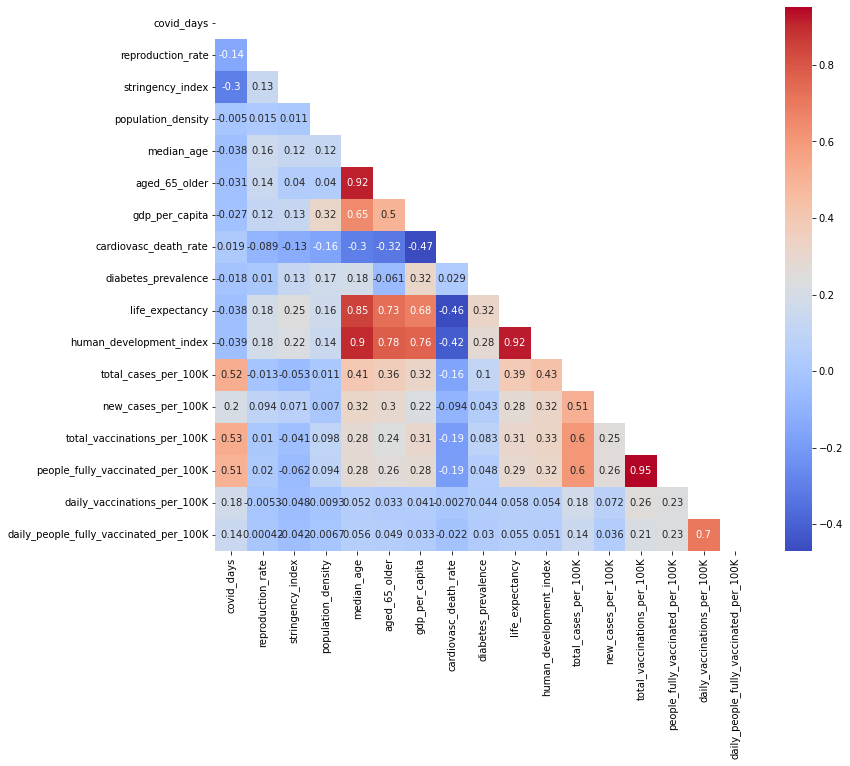

In [9]:
# Visualize the data
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(cases_2yr_df.corr(), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(cases_2yr_df.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.show()

In [10]:
# Define Target variable
y = cases_2yr_df.new_cases_per_100K
# Define features 
X = cases_2yr_df.drop(["new_cases_per_100K"], axis=1)

In [11]:
# Show statistical description of features
X.describe()

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000,88039.000000
mean,397.184214,1.019009,56.287148,202.690726,30.609044,8.986895,18837.181940,259.336216,7.305236,72.690433,0.724492,2190.664682,16993.456991,6945.010393,1610.546356,479.127657
std,182.664901,0.341300,21.317570,710.258836,9.383420,6.495824,19396.820407,122.120514,3.723424,7.680013,0.156609,3460.195736,39736.922315,17452.813095,11612.895509,4448.521001
min,22.000000,-0.030000,0.000000,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,241.000000,0.850000,43.520000,35.608000,21.500000,3.244000,3823.194000,156.139000,4.820000,66.600000,0.584000,69.844850,0.000000,0.000000,0.000000,0.000000
50%,391.000000,1.010000,57.410000,80.080000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.756000,408.312600,0.000000,0.000000,0.000000,0.000000
75%,553.000000,1.190000,72.220000,145.725000,39.600000,14.799000,27936.896000,329.635000,8.780000,77.970000,0.852000,2909.248150,2995.000000,70.000000,65.028774,1.060089
max,725.000000,5.820000,100.000000,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,24770.400400,226020.000000,90680.000000,223970.404410,90676.446187


In [12]:
# Split the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [13]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (66029, 16)
X_test shape: (22010, 16)
y_train shape: (66029,)
y_test shape: (22010,)


In [14]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# Check the scaled data
X_train_scaled

array([[-1.58743168,  0.58688403,  1.52604318, ..., -0.39790964,
        -0.1380577 , -0.10709081],
       [-1.44515096,  1.11341942,  1.2656088 , ..., -0.39790964,
        -0.1380577 , -0.10709081],
       [ 1.12684653, -1.2559898 , -1.98701054, ..., -0.39790964,
        -0.1380577 , -0.10709081],
       ...,
       [ 1.73974806, -1.2559898 , -2.63762809, ..., -0.39790964,
        -0.1380577 , -0.10709081],
       [-1.00189182,  0.06034865,  1.87313289, ..., -0.39790964,
        -0.1380577 , -0.10709081],
       [-0.98547482,  0.32361634,  1.43938786, ..., -0.39790964,
        -0.1380577 , -0.10709081]])

In [16]:
# Create a Random Forest Regression instance and train it
rf_model = RandomForestRegressor(n_estimators=128, random_state=78)

# Train the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [17]:
# Evaluate the model.
y_pred = rf_model.predict(X_test_scaled)
y_pred

array([1.77644141e+00, 3.21635859e+00, 2.50781250e-04, ...,
       1.59631172e+00, 2.50028984e+00, 3.97902344e-01])

In [18]:
# Score the model on testing data with R2, MAE, MSE, RMSE.
r2 = r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
RMSE = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f"R-squared (R2 ): {r2: .3f}")
print(f"mean absolute error (MAE): {mae: .3f}")
print(f"mean squared error (MSE): {mse: .3f}")
print(f"Root Mean Squared Error (RMSE): {RMSE: .3f}")

R-squared (R2 ):  0.774
mean absolute error (MAE):  2.672
mean squared error (MSE):  94.215
Root Mean Squared Error (RMSE):  9.706


In [19]:
# Check the training score
training_score = rf_model.score(X_train_scaled, y_train)
print(f"The training score for the Random Forest Regression model on 17 features is {training_score: .3f}.")

The training score for the Random Forest Regression model on 17 features is  0.968.


In [20]:
# Check the testing score
testing_score = rf_model.score(X_test_scaled, y_test)
print(f"The testing score for the Random Forest Regression model on 17 features is {testing_score: .3f}.")

The testing score for the Random Forest Regression model on 17 features is  0.774.


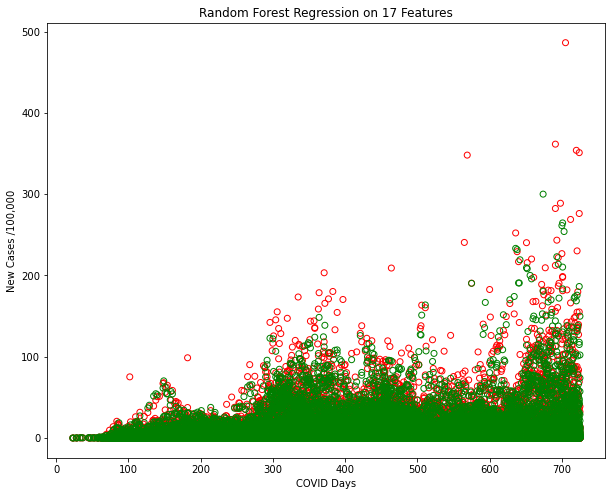

In [21]:
# Visualize the predication against the actual values
plt.figure(figsize=(10, 8))
plt.scatter(X_test['covid_days'].values, y_test, facecolors='none', edgecolors='r')
plt.scatter(X_test['covid_days'].values, y_pred, facecolors='none', edgecolors='green')

plt.title('Random Forest Regression on 17 Features')
plt.xlabel('COVID Days')
plt.ylabel('New Cases /100,000')
plt.show() 

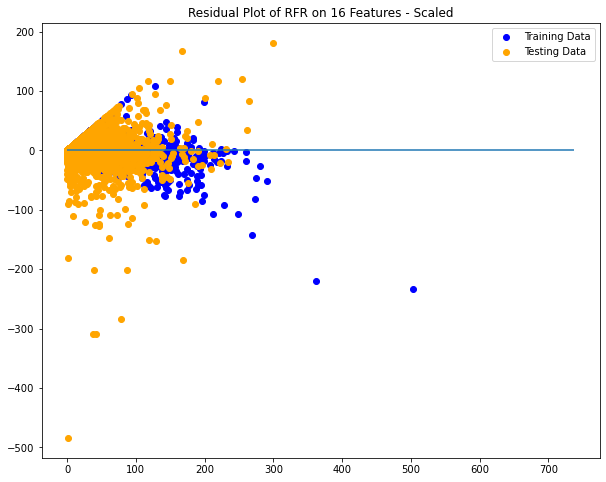

In [24]:
# Plot the predictions and their residuals for the training and testing data - SCALED.

plt.figure(figsize=(10, 8))
plt.scatter(rf_model.predict(X_train_scaled), rf_model.predict(X_train_scaled) - y_train, c="blue", label="Training Data")
plt.scatter(rf_model.predict(X_test_scaled), rf_model.predict(X_test_scaled) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot of RFR on 16 Features - Scaled")
plt.show()

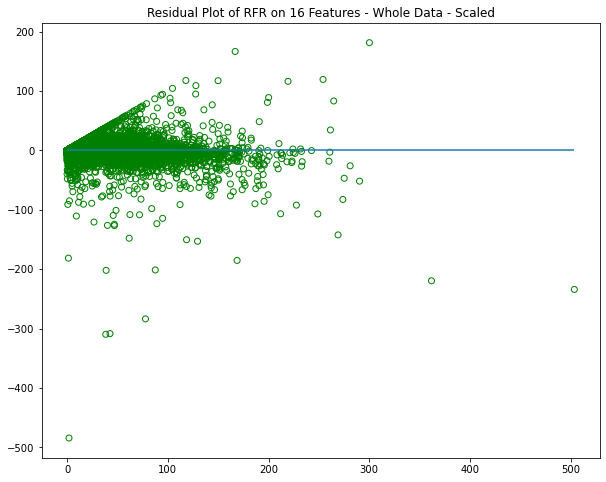

In [23]:
# Scale the whole data
X_scaled = X_scaler.transform(X)
pred_16_scaled = rf_model.predict(X_scaled)
# Plot predictions from scaled data and their Residuals
plt.figure(figsize=(10, 8))
plt.scatter(pred_16_scaled, pred_16_scaled - y, facecolors='none', edgecolors='green')
plt.hlines(y=0, xmin=pred_16_scaled.min(), xmax=pred_16_scaled.max())
plt.title("Residual Plot of RFR on 16 Features - Whole Data - Scaled")
plt.show()

In [26]:
# # Create a new focused DataFrame of results of regression with their errors 
# predictions = rf_model.predict(X)
# regression_notscaled_df = pd.DataFrame({"Actual": y, "Predicted": predictions, "Error": predictions - y})[["Actual", "Predicted", "Error"]]
# regression_notscaled_df.head(5)

In [27]:
# Scale the whole data
# X_scaled = X_scaler.transform(X)
# pred_16_scaled = rf_model.predict(X_scaled)
regression_scaled_df = pd.DataFrame({"Actual": y, "Predicted": pred_16_scaled, "Residuals": pred_16_scaled - y})[["Actual", "Predicted", "Residuals"]]
regression_scaled_df.head(5)

,Actual,Predicted,Residuals
id_row,,,
34,0.0201,0.026097,0.005997
35,0.0000,0.019259,0.019259
36,0.1305,0.098776,-0.031724
37,0.0653,0.074001,0.008701
38,0.1079,0.087219,-0.020681


In [28]:
# Add a new column "predictions" to the original Dataframe that holds the actual new cases. 
pred_720d_rfr_df = cases_2yr_df.copy()
pred_720d_rfr_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_720d_rfr_df.shape)
pred_720d_rfr_df.head()

(88039, 18)


,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,
34,88,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0201,0.0,0.0,0.0,0.0,0.026097
35,89,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.2862,0.0000,0.0,0.0,0.0,0.0,0.019259
36,90,1.53,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4167,0.1305,0.0,0.0,0.0,0.0,0.098776
37,91,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.4820,0.0653,0.0,0.0,0.0,0.0,0.074001
38,92,1.52,67.59,54.422,18.6,2.581,1803.987,597.029,9.59,64.83,0.511,0.5899,0.1079,0.0,0.0,0.0,0.0,0.087219


In [29]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions.
pred_720d_rfr_df['Residuals'] = pred_720d_rfr_df['new_cases_per_100K_predictions'] - pred_720d_rfr_df['new_cases_per_100K']
print(pred_720d_rfr_df.shape)
pred_720d_rfr_df.sample(5)

(88039, 19)


,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,
138658,355,0.93,62.50,778.202,20.4,3.043,4449.898,265.910,10.59,74.05,0.708,2373.1723,24.9294,0.0,0.0,0.0,0.0,26.188893,1.259493
73365,390,1.03,59.72,157.834,22.9,4.694,7423.808,155.898,10.18,74.30,0.663,846.1979,1.1945,0.0,0.0,0.0,0.0,1.800216,0.605716
11741,545,0.70,60.19,106.749,44.4,19.202,45436.686,145.183,6.35,81.54,0.922,7141.8540,0.8072,0.0,0.0,0.0,0.0,0.897843,0.090643
189989,103,0.82,62.96,19.751,35.6,14.655,20551.409,160.708,6.93,77.91,0.817,13.8588,0.0861,0.0,0.0,0.0,0.0,0.118144,0.032044
137704,570,1.31,69.44,255.573,23.5,4.495,5034.708,423.031,8.35,67.27,0.557,446.1342,2.0693,0.0,0.0,0.0,0.0,1.714220,-0.355080


In [30]:
# # Export the RFR predictions DataFrame to a csv file.
# pred_720d_rfr_outpath = Path("./Resources/pred_720d_rfr.csv")
# pred_720d_rfr_df.to_csv(pred_720d_rfr_outpath, index=True)

## Adding Predictions and Residuals to Original DataFrame

In [31]:
# Add a new column "predictions" to the original Dataframe that holds the actual new cases. 
pred_720d_rfr_all_df = df.copy()
pred_720d_rfr_all_df['new_cases_per_100K_predictions'] = pred_16_scaled
print(pred_720d_rfr_all_df.shape)
pred_720d_rfr_all_df.head()

(88039, 26)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0,0.026097
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0,0.019259
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0,0.098776
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0,0.074001
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0,0.087219


In [32]:
# Add a new column "residuals" to the Dataframe that holds the actual new cases and predictions.
pred_720d_rfr_all_df['Residuals'] = pred_720d_rfr_all_df['new_cases_per_100K_predictions'] - pred_720d_rfr_all_df['new_cases_per_100K']
pred_720d_rfr_all_df.sample(5)

,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K,new_cases_per_100K_predictions,Residuals
id_row,,,,,,,,,,,,,,,,,,,,,
91357,Japan,620,1644747.0,7213.0,0.59,150895329.0,67685775.0,52.31,126050796.0,347.778,...,1218013.0,597650.0,1304.8287,5.7223,119710.0,53700.0,966.287432,474.134253,5.896078,0.173778
1812,Albania,132,876.0,4.0,0.94,0.0,0.0,89.81,2872934.0,104.871,...,0.0,0.0,30.4915,0.1392,0.0,0.0,0.000000,0.000000,0.184692,0.045492
138453,Palestine,150,447.0,1.0,1.10,0.0,0.0,80.56,5222756.0,778.202,...,0.0,0.0,8.5587,0.0191,0.0,0.0,0.000000,0.000000,0.028095,0.008995
48542,Djibouti,413,6006.0,25.0,1.23,0.0,0.0,37.96,1002197.0,41.285,...,0.0,0.0,599.2834,2.4945,0.0,0.0,0.000000,0.000000,1.750836,-0.743664
89661,Italy,665,4752368.0,4595.0,1.24,89456555.0,42956221.0,73.15,60367471.0,205.859,...,183494.0,55745.0,7872.3987,7.6117,148190.0,71160.0,303.961715,92.342778,7.513404,-0.098296


In [33]:
# Export the RFR predictions DataFrame to a csv file.
pred_720d_rfr_all_outpath = Path("./Resources/pred_720d_rfr_all.csv")
pred_720d_rfr_all_df.to_csv(pred_720d_rfr_all_outpath, index=True)